In [9]:
# from deepiforest.algorithms.dif import DIF

import sys
import os
sys.path.append(os.path.abspath("../../deep-i-forest/deep-iforest"))
from algorithms.dif import DIF

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [1]:
import matplotlib
print(matplotlib.__file__)


/opt/miniconda3/envs/deepiforest/lib/python3.9/site-packages/matplotlib/__init__.py


In [10]:
data = pd.read_csv('vacuum_sensor_data.csv', sep = ';')
data

,momento,1-0005,5-0005,1-_006,5-_006,1-_007,5-_007,1-_008,5-_008,1-_010,...,1-_098,5-_098,1-_099,5-_099,1-0112,5-0112,1-0116,5-0116,1-0109,5-0109
0,1,-588.88,-580.21,-590.50,-582.25,-593.51,-585.46,-595.51,-587.47,-575.36,...,-588.17,-581.42,-594.26,-586.26,-589.46,-581.75,-592.92,-586.26,-593.93,-586.30
1,2,-588.38,-579.71,-590.80,-582.46,-593.80,-585.67,-595.55,-587.59,-574.11,...,-588.34,-581.63,-594.51,-586.26,-589.29,-581.58,-592.80,-586.26,-594.13,-586.51
2,3,-584.41,-575.74,-585.83,-577.66,-591.38,-583.21,-589.84,-578.04,-563.34,...,-588.17,-581.33,-592.88,-584.34,-588.50,-580.62,-590.21,-583.75,-593.68,-585.84
3,4,-573.73,-565.27,-570.31,-562.81,-578.91,-571.24,-578.61,-565.90,-555.00,...,-584.79,-576.87,-580.62,-568.15,-586.96,-578.75,-578.66,-571.19,-590.88,-582.63
4,5,-567.27,-558.55,-562.26,-554.55,-570.69,-562.93,-567.18,-557.51,-545.99,...,-579.11,-570.99,-572.11,-560.43,-583.45,-574.91,-571.06,-563.56,-587.38,-578.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,637,-237.18,-253.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,638,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,639,-237.14,-253.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,640,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#rename column to have consistent naming 
import re

def clean_column(col):
    if col == 'momento':
        return col
    match = re.match(r"(\d)-_?(\d+)", col)
    if match:
        sensor, comp = match.groups()
        return f"{sensor}-{int(comp):04d}"
    return col  # fallback in case format is already correct

# Apply renaming
data.columns = [clean_column(col) for col in data.columns]

In [12]:
# drop rows(seconds) where data from any sensor is missing
data=data.dropna(axis=0)

In [13]:
data.shape

(533, 77)

In [7]:
train_columns = [col for col in data.columns if col not in ['1-0116', '5-0116', '1-0109', '5-0109']]
df_train = data[train_columns]


In [8]:
validation_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
df_validation = data[['momento'] + validation_columns]

In [14]:
# Remove first 30 seconds from all data
data_filtered = data[data['momento'] >= 30].reset_index(drop=True)


In [15]:
#split columns into train and validation
defective_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
normal_control_columns = ['1-0008', '5-0008', '1-0064', '5-0064']
validation_columns = defective_columns + normal_control_columns

df_validation = data_filtered[['momento'] + validation_columns]
train_columns = [col for col in data_filtered.columns if col not in validation_columns]
df_train = data_filtered[train_columns]


In [ ]:
#prepare training data as time series:
# Drop 'momento' and only keep sensor columns used for training
X_train_raw = df_train.drop(columns=['momento'])

# Transpose so each row = one component's signal over time
X_train_transposed = X_train_raw.T  # shape: (n_components, n_timesteps)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transposed)

#So you scale shape (n_components, n_timesteps), meaning:
#Each time point becomes a feature
#Scaling happens across components, not across time
# This means second 100 (the important anomaly region) is scaled relative to other components' second 100, not to the component's own baseline.
#This can mask anomalies.

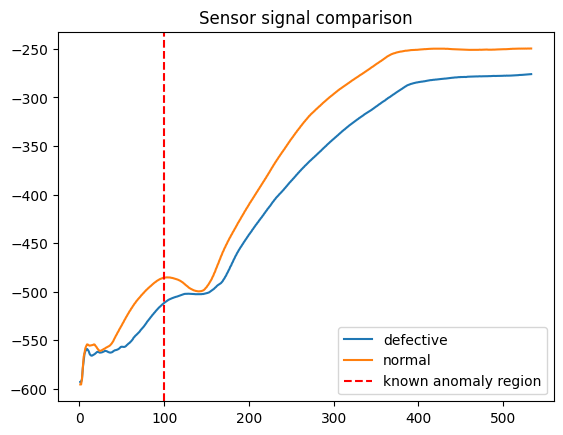

In [ ]:
#plot example normal vs defective

plt.plot(data['momento'], data['1-0116'], label='defective')
plt.plot(data['momento'], data['1-0008'], label='normal')
plt.axvline(100, color='red', linestyle='--', label='known anomaly region')
plt.legend()
plt.title("Sensor signal comparison")
plt.show()


In [ ]:
#train DIF
dif = DIF(
    n_ensemble=100,
    n_hidden=[500, 100],
    n_emb=20,
    activation='tanh',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1
)
dif.fit(X_train_scaled)


In [32]:
# 1. Get anomaly scores
scores = dif.decision_function(X_val_scaled)

# 2. Manually define your contamination rate
contamination = 0.05  # 5% expected anomalies

# 3. Compute threshold based on contamination
threshold = np.percentile(scores, 100 * (1 - contamination))

# 4. Predict: 1 = anomaly, 0 = normal
preds = (scores >= threshold).astype(int)


In [34]:
#define y_val - ground truth, components that are actually defective

# Get component names in same order as X_val (which is transposed)
component_names = df_validation.drop(columns=['momento']).columns.tolist()

# Label: 1 if defective, 0 if normal
label_map = {col: 1 if col in defective_columns else 0 for col in component_names}
y_val = [label_map[col] for col in component_names]


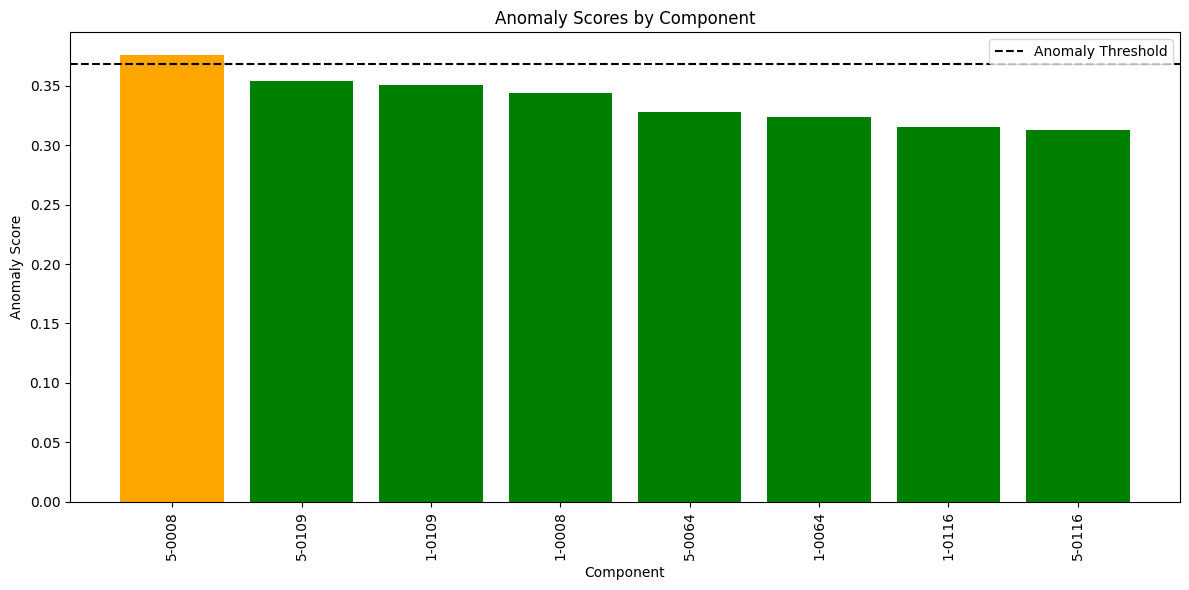

In [35]:

# Get component names (in same order as X_val_scaled)
component_names = df_validation.drop(columns=['momento']).columns.tolist()

# Create color map based on ground truth and predictions
colors = []
for true, pred in zip(y_val, preds):
    if true == 1 and pred == 1:
        colors.append('red')    # True positive (defective + detected)
    elif true == 0 and pred == 1:
        colors.append('orange') # False positive (normal but flagged)
    else:
        colors.append('green')  # Correct normal (true negative)

# Sort by score (optional)
sorted_indices = np.argsort(scores)[::-1]  # descending
sorted_scores = np.array(scores)[sorted_indices]
sorted_names = np.array(component_names)[sorted_indices]
sorted_colors = np.array(colors)[sorted_indices]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_names, sorted_scores, color=sorted_colors)
plt.axhline(y=threshold, color='black', linestyle='--', label='Anomaly Threshold')
plt.title("Anomaly Scores by Component")
plt.xlabel("Component")
plt.ylabel("Anomaly Score")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
print(set(df_train.columns) & set(defective_columns))


set()
